# Compton Scattering is anisotropic

Compton Scatterin is anisotropic and so photons on extract need to be reweighted.
This notbooks is intended to summarize how we arrived at a reweighting approach for
Compon scattering.

At low frenquence, electron scattering has a dipole radiation pattern; at higher freqencies the emission is froward scatteted with respect to the incident photon directon.  

For the purpose of Compton scattering we assume photons are scattered in the local rest frame of the electron that does the scattering.  Prior to reweighting we determine the direction we want to extract in given direction would have in this frame.  None of that is considereed here.

In [125]:
import os
os.getcwd()

'/Users/long/Dropbox/ksl/Projects/Jupyter'

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [127]:
h=6.6262e-27
m_e=9.10956e-28
c=2.997925e10

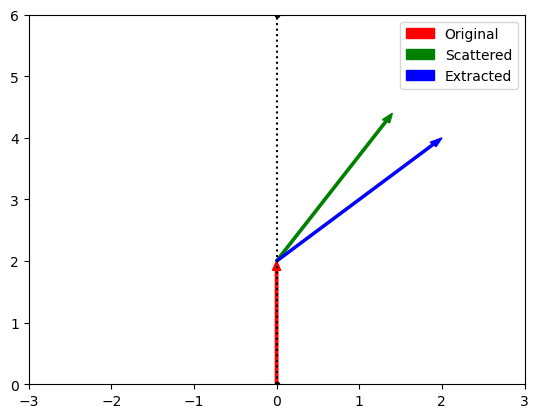

In [128]:
plt.figure(1)



plt.arrow(0,0,0,2,head_width = 0.1,
          width = 0.03,color='red',label='Original',length_includes_head=True)

plt.arrow(0,2,1.4,2.4,color='green',head_width=0.1,width=0.03,label='Scattered',length_includes_head=True)
plt.arrow(0,2,2,2,color='blue',head_width=0.1,width=0.03,label='Extracted',length_includes_head=True)
plt.plot([0,0],[0,6],':.k')
plt.xlim(-3,3)
plt.ylim(0,6)
plt.legend()

We want to understand the situation above, where a photon $p_o$ comes from below, and scatters in a direction $\theta_{scat}$ so that it has a different frequency and weight. We could find out how many photons scatteredf in a certain direction via a random process by simply counting photons.  We are only interested in photons which scatter in certain directions and we would like to use an extract process instead, accouning for the fact that Compton scattering is not isotropic.

In Compton scattering the frequeency of a photon changes because of recoil

$$
\nu_{scat} = \frac{\nu_o}{1+\frac{h \nu}{m_e c^2}(1-cos \theta}
$$

The cross section for compton scattering is given by

$$
\frac{\delta \sigma}{\delta \Omega} = =C \left( \frac{\nu_{scat}}{\nu_o} \right )^2 \left ( \frac{\nu_o}{\nu_{scat}} + \frac{\nu_{scat}}{\nu_o} - sin^2 \theta  \right )
$$

The normalized proability function for scattering in a given $\theta$  direction is

$$
f(\theta)=C \left( \frac{\nu_{scat}}{\nu_o} \right )^2 \left ( \frac{\nu_o}{\nu_{scat}} + \frac{\nu_{scat}}{\nu_o} - sin^2 \theta  \right ) sin \theta
$$

Note tht this is essentially
$
d\sigma / d \Omega
$ aside from a normalization

The alternative thought (which CK advocates) is that one does not need to go through all this rigamarole.  All we actually need to do is write

$$
w_{extract}=\frac{f(\theta_{extract})}{1/4\pi}\frac{\nu_{extract}}{\nu_o} w_o
$$

Implementation thoughts

* In the Thompson limit the equations become simpler and 

$$
\frac{d\sigma}{d\Omega} \propto 2 - sin^2 \theta
$$

The reweighting and the any of the necessary functions are easy to calculate in this case.  

* In the real Compton case $f\theta$ depends upon R, and in that case it seems likely that it has to be computed for different energies.  That is a not really an issue though, becuase the formula for calculating I($\pi$) and I(0) is clear.



## Simulate Comptons scattering

The first few routines are just for testing

In [129]:
def random_three_vector(n=1e7):
    '''
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algorithm from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    '''
    phi = np.random.uniform(0,np.pi*2,int(n))
    costheta = np.random.uniform(-1,1,int(n))

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return [x,y,z]



def get_iso(n=1e7):
    '''
    Generate a bunch of photons with a uniform spherical distribution
    '''
    
    x,y,z=random_three_vector(n)
  
    x=Table([x,y,z],names=['x','y','z'])
    x['weight']=1.
    
    return(x)

iso=get_iso(1e7)

In [130]:
def get_flux(theta=45,dtheta=1,photons=iso):
    '''
    Simulate live or die, namely get the flux per SR at a particular angle, where theta is respect to z axis.
    
    where theta is the angle for extraction
        dtheta is the acceptance angle,
        and photons is a sets of photons, whose direction is specified by xyz
    '''
    r=photons['x']* photons['x']+photons['y']*photons['y']+photons['z']*photons['z']
    r=np.sqrt(r)
    photons['theta']=np.arccos(photons['z']/r)

    theta_min=(theta-dtheta)/(180/np.pi)
    theta_max=(theta+dtheta)/(180/np.pi)
    
    # print(theta_min,theta_max)
    # 
    x=photons[photons['theta']>theta_min]
    xx=x[x['theta']<theta_max]
    
    # print(len(photons),len(x),len(xx))
    
    domega=2*np.pi*np.sin(theta/(180/np.pi))*(theta_max-theta_min)
    
    flux=np.sum(xx['weight'])/domega
    return flux
                        

get_flux()

796236.2987787512

In [131]:
get_flux(90)

795838.8888548597

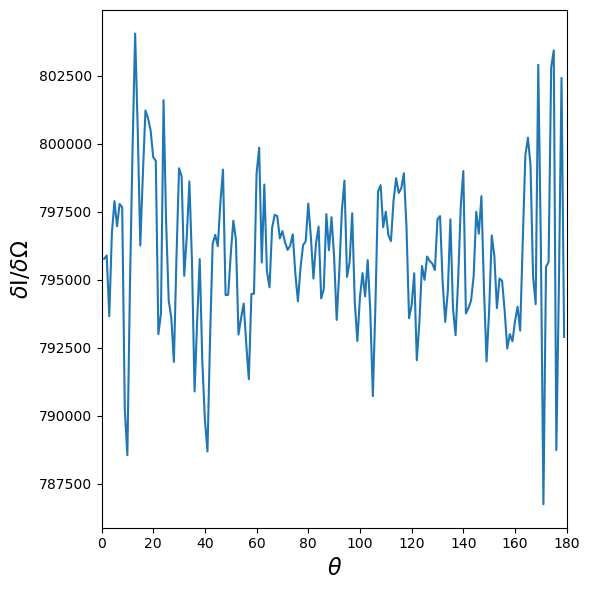

In [132]:
def plot_flux(photons=iso):
    '''
    Plot the fluxes.  
    Note that this routine is pretty slow
    '''
    f=[]
    angles=np.linspace(1,179,179)
    for one in angles:
        f.append(get_flux(one,1.,photons))
    
    
    plt.figure(1,(6,6))
    plt.plot(angles,f)
    plt.xlim(0,180)
    plt.xlabel(r'$\theta$',size=16)
    plt.ylabel(r'$\delta$I/$\delta \Omega$',size=16)
    plt.tight_layout()
               
    
plot_flux()

In [133]:
np.sqrt(798870.9252753567)

893.7957961835336

In [134]:
def one_dipole(np_phot_x_in=0,np_phot_y_in=0,np_phot_z_in=1.):
    '''
    Generate a dipole distribution
    '''
    mu_new= -1 + 2 * np.random.rand(1)
    phi=np.random.rand(1)*2.*np.pi
    while True:
        np_phot_x=np.sqrt(1-mu_new**2)*np.cos(phi)
        np_phot_y=np.sqrt(1-mu_new**2)*np.sin(phi)
        np_phot_z=mu_new
        
        cos_theta_scattering=np_phot_x*np_phot_x_in+np_phot_y*np_phot_y_in+np_phot_z*np_phot_z_in
        p_accept=0.5*(1+cos_theta_scattering*cos_theta_scattering)
        if (np.random.rand(1)<p_accept):
            break
        mu_new= -1 + 2 * np.random.rand(1)
        # phi=np.random.rand(1)*2.*np.pi
        
    return [float(np_phot_x),float(np_phot_y),float(np_phot_z)]
        
one_dipole()

[0.5597548488105629, -0.6752098735793248, 0.4803812401146157]

In [135]:
def gen_dipoles(np_phot_x_in=0,np_phot_y_in=0,np_phot_z_in=1.,nphot=1e6):
    i=0
    records=[]
    while i<nphot:
        records.append(one_dipole(np_phot_x_in,np_phot_y_in,np_phot_z_in))
        i+=1
    records=np.array(records)
    x=Table(records,names=['x','y','z'])
    x['weight']=1.
    return x

xdipole=gen_dipoles()

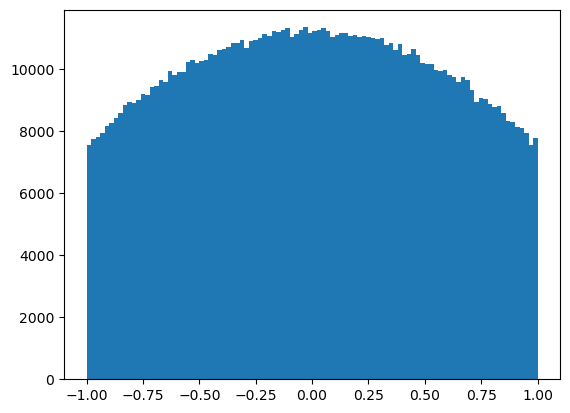

In [136]:
z=plt.hist(xdipole['x'],100)

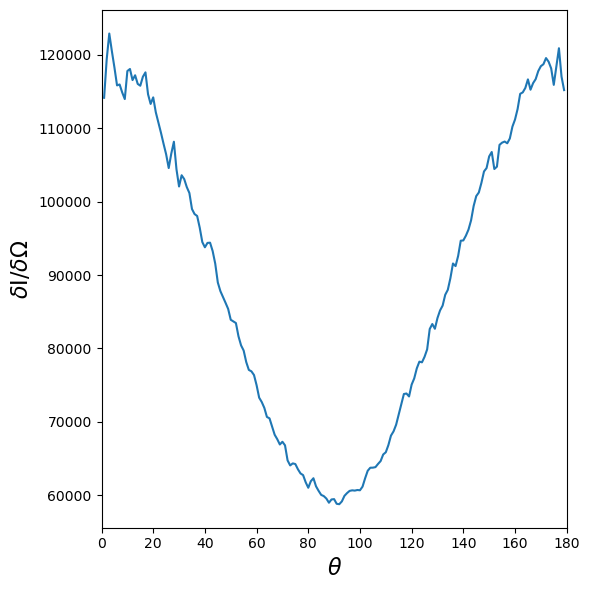

In [137]:
plot_flux(xdipole)

This is clearly what we expect for (unpolarized) dipole scatttering.  But how do I generate this with extract.  In fhis case I want to take every photon and reweight it.  Every photon is going to head in the direction that I want.  Evidently, I can get the angular distribution I want if, I add a factor to the weight that is

$$
0.5 * (1+cos^2 (\theta))
$$

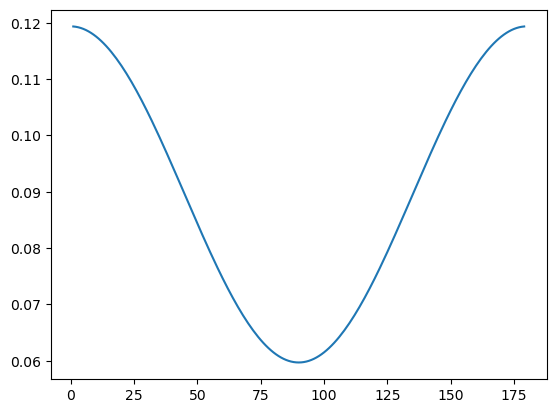

In [138]:
angles=np.linspace(1,179,179)
def reweight(theta=angles):
    xtheta=theta/(180/np.pi)
    xweight=1/(16./3.*np.pi)*(1+np.cos(xtheta)**2)
    return xweight

new=reweight()
plt.plot(angles,new)
# plt.plot(angles,1e6*new)
    

This has the same shape and the same normaliztion.

It was arrived at by integrating

$$
\sigma=\int \frac{d\sigma}{d\Omega} d\Omega = C \int  (1+cos^2 \theta) 2 \pi sin\theta d\theta = C \frac{16 \pi}{3}
$$

and comparing this to the isotropic case, where

$$
\sigma=\int \frac{d\sigma}{d\Omega} d\Omega = 4 \pi C'
$$

so the normalizing constant needs to be

$$
N= \frac{4\pi}{16\pi/3} = \frac{3}{4}
$$

Note that for tuecompton scattering, we need to calculate effectively the same factor, and we expect the proper normalization to end up as

$$
N \frac{4\pi}{Integral}
$$

In [139]:
1/(16./3*np.pi)

0.05968310365946076

## Will this work for Compton scattering, where the input photons have significant umph -- a technical term

The problem with doing this with true Compton scattering is one needs to calculate this for every input frequency

# Create code so we can compare the Thompson and Compton renormaliztion

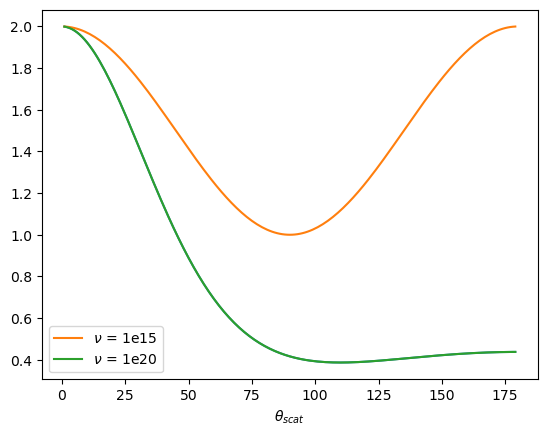

In [140]:
h=6.6262e-27
m_e=9.10956e-28
c=2.997925e10

angles=np.linspace(1,179,179)

def compton_reweight(nu_in=1e20,theta=angles):
    '''
    A function proportional to dsigma/domega for
    comptons scattering.  This is not
    properly reweighted.
    '''
    
    theta=theta/(180/np.pi)
    
    nu_out=nu_in/(1+h*nu_in/(m_e*c*c) * (1-np.cos(theta)))
    
    # print(nu_out)
    xr=nu_out/nu_in
    
    rho=xr*xr * (xr+1./xr - np.sin(theta)*np.sin(theta))
    
    return rho

z=compton_reweight()
zz=compton_reweight(1e15)
plt.plot(angles,z)
plt.figure(1,(6,6))
plt.plot(angles,zz,label=r'$\nu$ = 1e15')
plt.plot(angles,z,label=r'$\nu$ = 1e20')
plt.xlabel(r'$\theta_{scat}$')
plt.legend()

In order to get the proper normalization we need to be able to integrate

$$
I(\theta) =\int \left( \frac{\nu_{scat}}{\nu_o} \right )^2 \left ( \frac{\nu_o}{\nu_{scat}} + \frac{\nu_{scat}}{\nu_o} - sin^2 \theta  \right ) sin \theta d\theta
$$

The solution to this, according to multiple souces on the web is
$$
I(\theta) = 
-\frac{cos(\theta)}{R^2} \\
+ log((1+ R (1-cos\theta) ) \left ( \frac{1}{R}-\frac{2}{R^2} - \frac{2}{R^3}  \right ) \\
- \frac{1}{2R (1+R (1-cos \theta))^2} \\
+ \frac{1}{1+R(1-cos \theta)} \left ( - \frac{2}{R^2}  - \frac{1}{R^3} \right )
$$

where

$$
R=\frac{h\nu}{m_ec^2}
$$

Note that the eqation above is the indevinite integral.  It is actually negative at $\theta=0$, and only makes sense wih limits.

We want the difference between $I(\pi)-I(0)$

In [141]:
def Itheta(xtheta=np.pi,r=1):
    '''
    Calculate I(theta)
    '''
    xcos=np.cos(xtheta)
    x1=(-xcos/(r*r))
    x2=np.log(1.+r*(1-xcos))
    x3=1/r-2/(r*r)-2/(r*r*r)
    
    xx=(1+r*(1-xcos))
    
    x4=1./(2*r*xx*xx)
    
    x5=1/xx*(-2/(r*r)-1./(r*r*r))
    
    result=x1+x2*x3-x4+x5
    
    return result

def Itheta_norm(r=1):
    '''
    Get the normalization
    '''
    return (Itheta(np.pi,r)-Itheta(0,r))

Itheta_norm()
    
             
    

1.1486075784401155

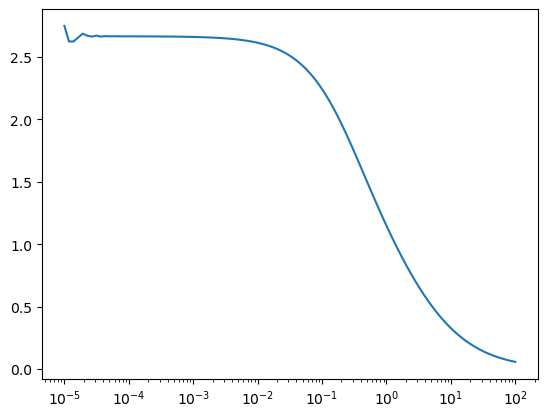

In [142]:
rr=np.logspace(-5,2,100)
# print(rr)
value=[]
for one in rr:
    value.append(Itheta_norm(one))
plt.semilogx(rr,value)

The implementation above is pretty awkward.  Lets try to simplify this a bit

In [143]:
def xnorm(r=1):
    
     # at pi

    x1=(2/(r*r))
    
    xx=1.+2.*r
    x2=np.log(xx)
    x3=1/r-2/(r*r)-2/(r*r*r)
    
    x4=1./(2*r) * (1/(xx*xx)-1.)
    
    x5=1/xx*(-2/(r*r)-1./(r*r*r))+(2/(r*r)+1./(r*r*r))
    
    # print('%10.4e %10.4e %10.4e %10.4e %10.4e' % (x1,x2,x2*x3,x4,x5))
    
    result1=x1+x2*x3-x4+x5
    
    # print(result1)
    
   

    
    return result1
xnorm()




1.1486075784401153

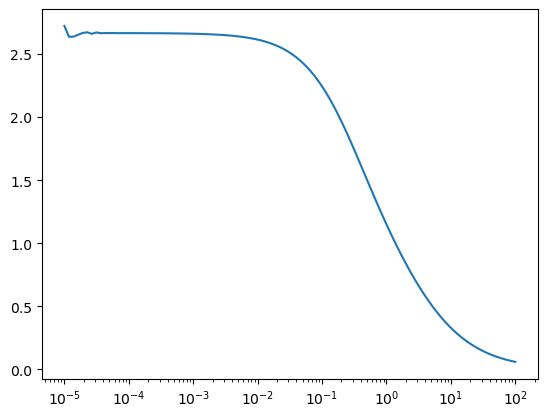

In [144]:
rr=np.logspace(-5,2,100)
# print(rr)
value=[]
for one in rr:
    value.append(xnorm(one))
plt.semilogx(rr,value)

**We should be able to get the same answer via direct integration**

In [145]:
from scipy import integrate

In [146]:
def integrand(x,a):
    return a*x*x

integrate.quad(integrand,0,3,args=(4))

(36.00000000000001, 3.9968028886505646e-13)

In [147]:
def comp_integrand(xtheta,r=1):
    prime=1./(1+r*(1-np.cos(xtheta)))
    sin=np.sin(xtheta)
    integrand=prime**2 * (1./prime+prime-sin*sin) * sin
    return integrand

integrate.quad(integrand,0,np.pi,args=(1))
    

(10.335425560099939, 1.1474627426122306e-13)

In [148]:
integrate.quad(comp_integrand,0,np.pi,args=(.001))

(2.661347164620288, 1.1056529025992122e-13)

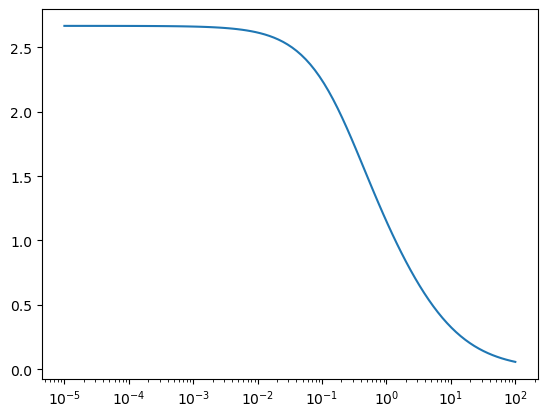

In [149]:
rr=np.logspace(-5,2,100)
# print(rr)
value=[]
error=[]
for one in rr:
    x1,x2=integrate.quad(comp_integrand,0.0,np.pi,args=(one))
    value.append(x1)
    error.append(x2)
plt.semilogx(rr,value)

# So at this point we should be able to check everything for Compton scattering

Note that what were are doing here is to account for the weighting that arises from having an isotropic distribution.  In the actuall code we have to also account for the fact that frequencies change.


Python (the c program) uses a fairly complicated rejection method for this; I propose to use the equations above instead

First do live or die.

In [150]:
def get_cdf(r=1):
    npts=100000
    theta=np.linspace(0,np.pi)
    values=Itheta(theta,r)
    xval=(values-values[0])/(values[-1]-values[0])
    return theta,xval      
    
    
get_cdf()
    

(array([0.        , 0.06411414, 0.12822827, 0.19234241, 0.25645654,
        0.32057068, 0.38468481, 0.44879895, 0.51291309, 0.57702722,
        0.64114136, 0.70525549, 0.76936963, 0.83348377, 0.8975979 ,
        0.96171204, 1.02582617, 1.08994031, 1.15405444, 1.21816858,
        1.28228272, 1.34639685, 1.41051099, 1.47462512, 1.53873926,
        1.60285339, 1.66696753, 1.73108167, 1.7951958 , 1.85930994,
        1.92342407, 1.98753821, 2.05165235, 2.11576648, 2.17988062,
        2.24399475, 2.30810889, 2.37222302, 2.43633716, 2.5004513 ,
        2.56456543, 2.62867957, 2.6927937 , 2.75690784, 2.82102197,
        2.88513611, 2.94925025, 3.01336438, 3.07747852, 3.14159265]),
 array([0.        , 0.00356657, 0.01412141, 0.03124308, 0.054271  ,
        0.08236162, 0.11455549, 0.14984674, 0.18724712, 0.22583904,
        0.26481419, 0.30349711, 0.34135464, 0.37799382, 0.41315115,
        0.44667621, 0.47851243, 0.50867704, 0.5372419 , 0.56431606,
        0.59003085, 0.61452742, 0.63794694, 0.

In [151]:
def gen_phot(r=0.01,nphot=1e7):
    
    phi=np.random.rand(int(nphot))*2.*np.pi
    theta,cdf=get_cdf(r)
    x=np.random.rand(int(nphot))
    x.sort()
    i=0
    j=0
    xtheta=[]
    while i<len(theta):
        while  j<len(x) and x[j]<cdf[i]:
            xtheta.append(theta[i])
            j+=1
        i+=1
    
    xtheta=np.array(xtheta)
    x = np.sin( xtheta) * np.cos( phi )
    y = np.sin( xtheta) * np.sin( phi )
    z = np.cos( xtheta )
    
    xtab=Table([x,y,z],names=['x','y','z'])
    return xtab    
        
    
xtab=gen_phot()
ytab=gen_phot(1.)
    
    
   

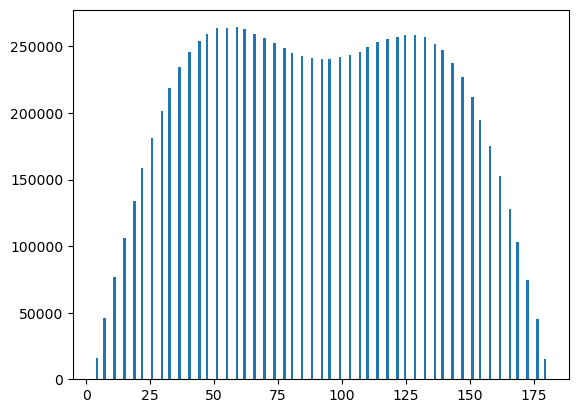

In [152]:
foo=plt.hist(np.arccos(xtab['z'])*57.29578,180,histtype='bar') 

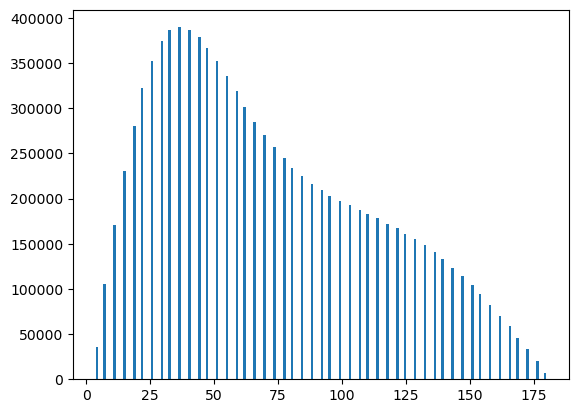

In [153]:
foo=plt.hist(np.arccos(ytab['z'])*57.29578,180,histtype='bar') 

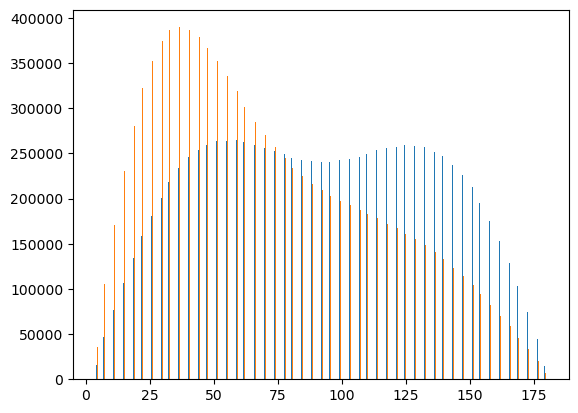

In [154]:
foo=plt.hist([np.arccos(xtab['z'])*57.29578,np.arccos(ytab['z'])*57.29578],180,histtype='bar') 

Now attempt to do extract

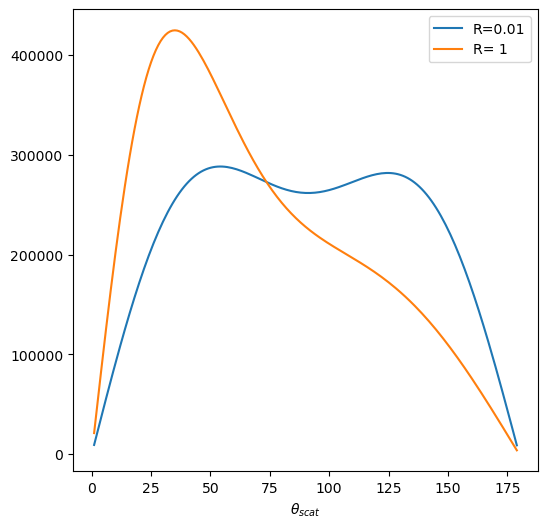

In [155]:
ngles=np.linspace(1,179,179)
nphot=1e7/180

def compton_extract(r=1,theta=angles):
    '''
    A function proportional to dsigma/domega for
    comptons scattering.  
    
    This properly normalized, due the the
    
    factor of 4*np.pi/xnorm which has been
    added.
    '''
    
    nu_in=r*m_e*c*c/h
    theta=theta/(180/np.pi)
    
    nu_out=nu_in/(1+h*nu_in/(m_e*c*c) * (1-np.cos(theta)))
    
    # print(nu_out)
    xr=nu_out/nu_in
    
    rho=xr*xr * (xr+1./xr - np.sin(theta)*np.sin(theta))
    
    rho*=np.sin(theta)
    
    rho*=4.*np.pi/xnorm(r)
    
    return rho

z=compton_extract()
zz=compton_extract(0.01)

plt.figure(1,(6,6))
plt.plot(angles,zz*nphot,label=r'R=0.01')
plt.plot(angles,z*nphot,label=r'R= 1')
plt.xlabel(r'$\theta_{scat}$')
plt.legend()

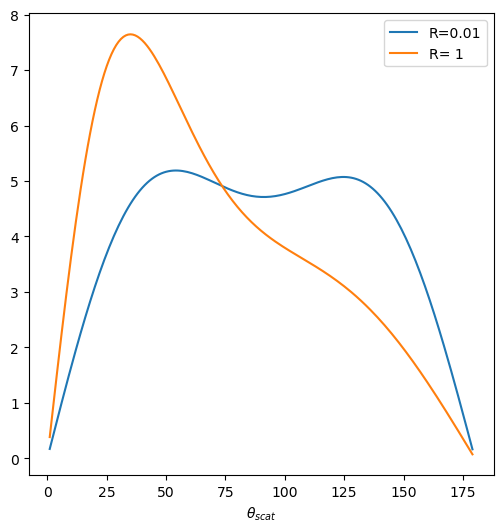

In [160]:
plt.figure(1,(6,6))
plt.plot(angles,zz,label=r'R=0.01')
plt.plot(angles,z,label=r'R= 1')
plt.xlabel(r'$\theta_{scat}$')
plt.legend()

## Conclusion

We now have a procedure for reweighting photons for extract in Python.  Implementation is relatively straightforward.



In [157]:
print(xnorm(1))


1.1486075784401153


In [158]:
xnorm(0.01)

2.6146853846694285